# Singular Value Decomposition on the Covariance vs. Data Matrix

While we have thus far focused on applying singular value decomposition to square symmatric matrices, it turns out that any real matrix **A** (not just square matrices!) can be decomposed into a set of 3 special matrices such that:

$
\mathbf{A} = \mathbf{U} \Sigma \mathbf{V}^T
$

With **U** and **V** being the eigenvectors of $\mathbf{AA}^{T}$ and $\mathbf{A}^{T}\mathbf{A}$, respectively.  We already know that when $\mathbf{A}$ is square and symmetric like the covariance or correlation matrix, $\mathbf{U}$ and $\mathbf{V}$ are simply the transpose of one another and contain the eigenvectors, and then $\Sigma$ in this case holds eigenvalues (in matrix form on the diagnonal, although Numpy and Scipy return them as a vector).  But for a non-square real matrix with dimensions $m \times n$, you can still accomplish the singular value decomposition -- the different is that now $\mathbf{U}$ is $m \times m$ and $\mathbf{V}$ is $n \times n$.  Having the dimensions of the columns of our data matrix, $\mathbf{V}^{T}$ therefore holds our eigenvectors, while $\Sigma$ contains what are called 'singular values'.  If $\mathbf{A}$ is positive semi-definite, the singular values $\sigma$ in $\Sigma$ and eigenvalues ($\lambda$) are related via:

$
\sigma = \sqrt{\lambda(n-1)}
$

So, squaring the singular values $\sigma$ in $\Sigma$ and dividing by the sample size less 1 recovers eigenvalues from singular values. 

Let's look at a simple example first to convince ourselves we can do SVD on the covariance or correlation matrix, but also in most cases directly on the centered data matrix.  

First, let's import our packages:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

## Example using the Iris dataset

Let's read in our Iris dataset - remember, we did a very simple initial EOF analysis of part of these data when we first learned about eigenvectors and eigenvalues.

With this simple 2 column, 50 row matrix, I want to show you that performing the singular value decomposition on the data matrix can give us the same information we got using SVD on the covariance matrix:

In [2]:
df = pd.read_csv('iris.data') # use Pandas to read in the csv data

# extract just one species and just the sepal measurements
iris = df.loc[df[" species(id)"].str.contains('Iris-setosa'), ["sepal length (cm)"," sepal width (cm)"]].copy()

# remove the mean of each of the 2 columns of data
iris = iris - np.mean(iris,axis=0)

# calculate the covariance matrix for the 50x2 data matrix
C = np.cov(iris,rowvar=False,ddof=1)

# do the SVD on the square covariance matrix (2x2)
Uc,Sc,Vc = np.linalg.svd(C)
print(Uc)

# now, do the SVD directly on the centered data matrix (50x2)
Ud, Sd, Vd = np.linalg.svd(iris)
print(Vd.T)

# by printing both eigenvector matrices above, we can see for ourselves that we can get the same eigenvectors!  
# And we can check: are the two matrices the same (within machine tolerance)?  Yes they are!
np.allclose(Uc,Vd.T)

[[-0.66941065 -0.74289258]
 [-0.74289258  0.66941065]]
[[-0.66941065 -0.74289258]
 [-0.74289258  0.66941065]]


True

So it is possible to get the eigenvectors directly from the centered data matrix!  

Now, let's look at an example with a larger dataset - but in any case the principal is the same, whether a small array or a large one. 

## Example using the SST dataset

Now that we've done the simple example, let's do the same test on our SST dataset.  In theory, performing the SVD on the data matrix (which will have a smaller row dimension than the covariance matrix) will be faster and we can use `np.linalg.svd` directly on the data matrix.  First let's get the SST data ready for analysis - in previous notebooks we've done this step-by-step, but this part should be familiar by now:

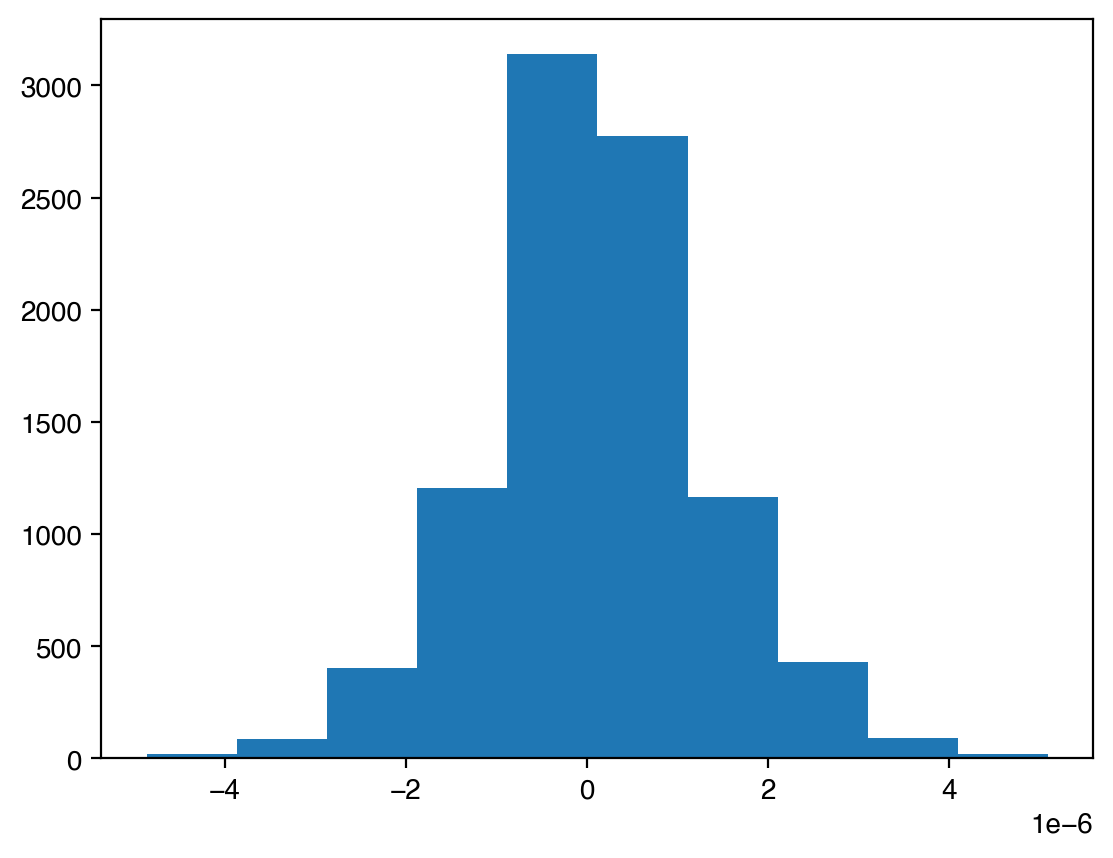

In [3]:
# open our file into a DataSet 
ds = xr.open_dataset('HadISST_sst.nc') 

# pull the sst variable out of the DataSet. 
sst = ds.sst

# turn negative SST values (sea ice) in NaNs
sst = sst.where(sst >= 0, np.nan)

# for working on the Pacific domain, we change the longitudes from -180,180 to 0,360 
sst = sst.assign_coords(longitude=(sst.longitude % 360))
sst = sst.sortby(sst.longitude)

# defined our latitude bounds
min_lat = -20.0
max_lat = 60.00

# define our longitude bounds
min_lon = 120
max_lon = 260

# slice and overwrite sst with the output 
sst = sst.sel(longitude=slice(min_lon,max_lon),latitude=slice(max_lat,min_lat))

# extract coordinates from the DataArray as well 
lat = sst.latitude
lon = sst.longitude

# Calculate the 5-month rolling mean
sst_ = sst.rolling(time=5).mean(skipna=True)

# Select out month 3 (March) to get the average over NDJFM
winter = sst_[sst_.time.dt.month == 3]

# use drop_isel to drop the first year
winter = winter.drop_isel(time=0)

# get the values from the winter DataArray - at this point they are still 3-dimensional
sst2d = winter.values

# record their original dimensions before we reshape
ntime, nrow, ncol = sst2d.shape

# now reshape, we want rows of the time variable and columns of location - we use 'order=F' because this gives us the correct reshaping
sst2d = np.reshape(sst2d, (ntime, nrow * ncol), order='F')

# index for where theere are no missing values at all (will eliminate land and some sea ice locations)
noMissing = ~np.isnan(sst2d).any(axis=0)

# create a new array with only the columns of sst2d that are not missing any data 
sst2dcomplete = sst2d[:, noMissing]

# calculate the anomalies from the long-term seasonal mean for each column
sst_anomalies = sst2dcomplete - np.mean(sst2dcomplete,axis=0)
plt.hist(np.mean(sst_anomalies,axis=0)); # and then a quick sanity check on the mean of the columns before we move on


Now we're ready.  Let's do SVD _both_ on the covariance matrix (using `sp.sparse.linalg.svds` to speed things up) and then on the on the centered data matrix using `np.linalg.svd`:

In [4]:
# using the covariance matrix now:
C = np.cov(sst_anomalies,rowvar=False,ddof=1)
Ux, Sx, Vx = sp.sparse.linalg.svds(C,k=9) # economy sized, only get the first ten eigenvalues/eigenvectors
sort_index = np.argsort(Sx)[::-1] # sort in descending order from high to low
Sx = Sx[sort_index] # apply the index
Ux = Ux[:,sort_index] # apply the index
Vx = Vx[sort_index,:] # apply the index

## we could use sp.sparse.linalg.svds for the data matrix, too, but let's us np.linalg. svd to prove we can do it quickly enough in the section below this one
# U, S, V = sp.sparse.linalg.svds(sst_anomalies,k=9) # 
# sort_index2 = np.argsort(S)[::-1] # sort in descending order from high to low
# S = S[sort_index2] # apply the index
# U = U[:,sort_index2] # apply the index
# V = V.conj().T # for the non-square data matrix, the eigenvectors are in the columns of the (conjugate) transpose of V
# V = V[:,sort_index2] # apply the sort index

# using the data matrix here - np.linalg.svd should be properly sorted from highest to lowest singular value
U, S, V = np.linalg.svd(sst_anomalies,full_matrices=False) # 4.1 seconds on my computer

print(U.shape, S.shape, V.shape)


(153, 153) (153,) (153, 9329)


Looking at the output from the SVD on the data matrix, we see the following:

* U is 153 by 153 (so, square with the dimensions of the time dimesion of our data matrix)
* S has 153 singular values (but not eigenvalues, yet!)
* V is 9329 vy 9329 (so, square with the spatial dimensions - the columns - so this must be the eigenvectors)

If we want the eigenvalues, we'll need to convert them, but also be aware that the singular values are proportional to the eigenvalues, so if all we are interested in is the variance accounted for by each mode, we could just use the singular values are they are.

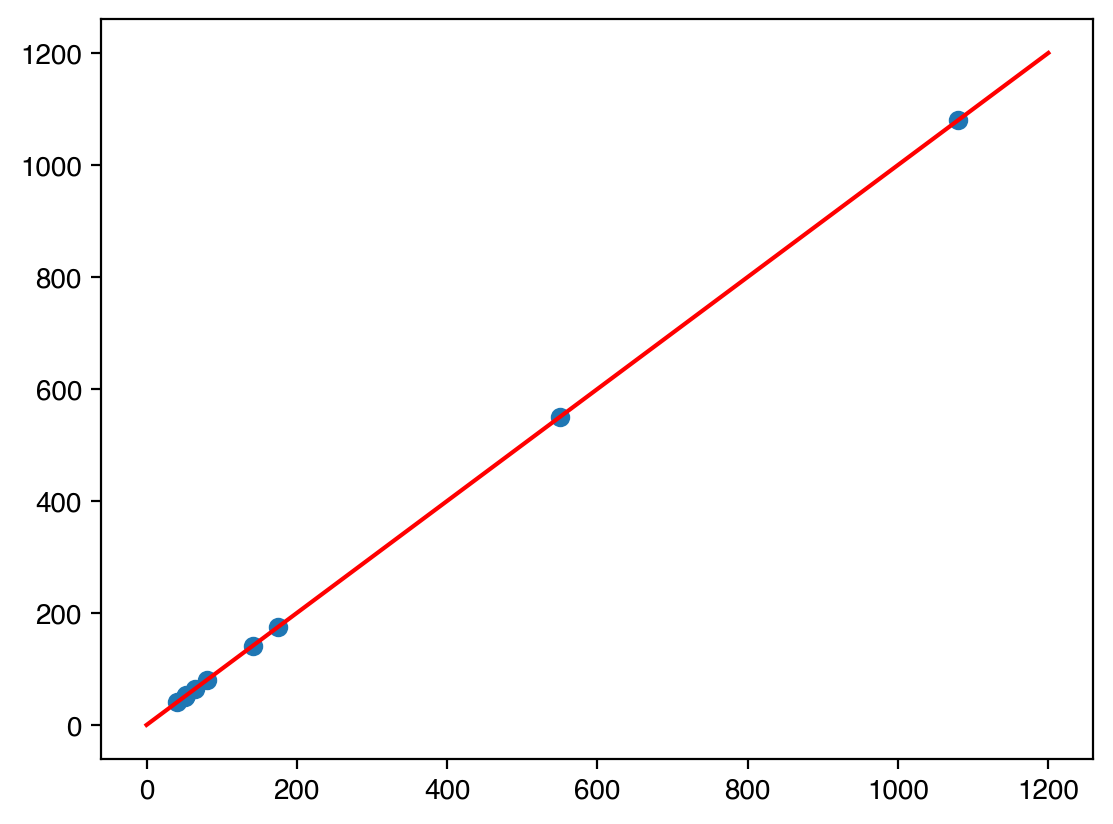

In [5]:
# the eigenvalues are the squared singular values divided by the unbiased sample size (n-1)
eigenvalues_from_singular_values = (S**2)/(len(S)-1)

# let's prove to ourselves this works - let's scatter plot the first 10 eigenvectors and the converted singular values:
plt.scatter(eigenvalues_from_singular_values[0:9],Sx[0:9])
plt.plot([0,1200],[0,1200],color="red")

Now, let's compare the leading eigenvectors from the SVD on the covariance matrix and on the data matrix.  Just remember that since the sign is arbitrary (and often linked to how the computer is doing the maths behind the scenes), they could be opposite signed (indeed, if you run this notebook multiple times, the sign may change between consecutive runs!)

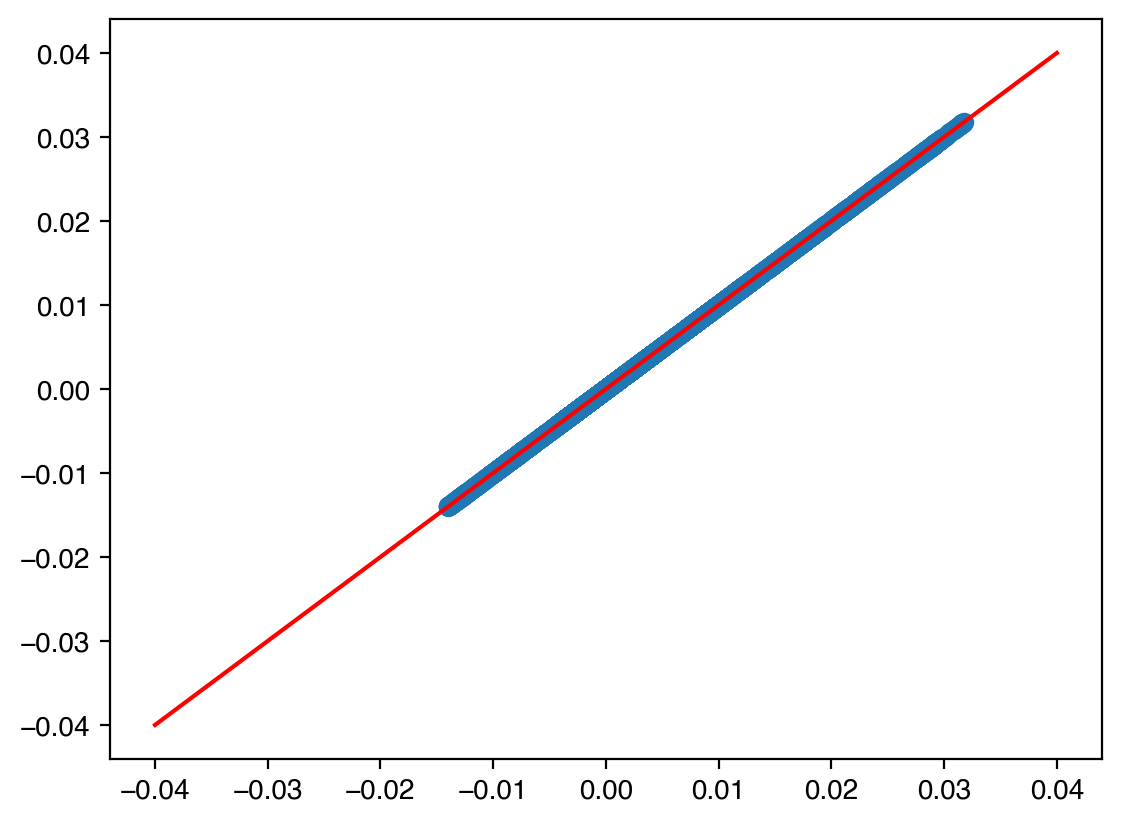

In [6]:
# Take a look at the leading eigenvectors - here in the transpose of V (remember they could be differently signed, but that sign is arbitary)
plt.scatter(Ux[:,0],V.T[:,0])
plt.plot([-0.04,0.04],[-0.04,0.04],color="red")

It is worth thinking for a moment why I had you use SVD on the covariance or correlation matrix when we first learned about EOF analysis - I wanted to make the connection explicit about where the space-time patterns we isolate in EOF analysis come from and the connection to the variance and covariance within our dataset.  In the future, applying SVD directly to the data matrix may in some cases be faster and more efficient that using the covariance matrix.